In [1]:
import xarray as xr
import reverse_geocoder as rg
from tqdm import tqdm
import pandas as pd
import itertools
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pickle as pkl

### Rainfall Calculation

In [65]:
weip_22=pd.read_csv(r"C:\\Daten\\Foschung\\RiskAware\\Data\\Weather\\waterscarcity2022.csv")
weip=pd.read_csv(r"C:\\Daten\\Foschung\\RiskAware\\Data\\Weather\\waterscarcity.csv")
weip_22.drop(columns=['unit_label','dimension_label','eu_sdg','dimension','unit','geo_label','obs_status'],inplace=True)
weip.drop(columns=['OBS_FLAG','unit','freq','DATAFLOW','LAST UPDATE'])
weip_table=weip.pivot_table(values='OBS_VALUE',index='TIME_PERIOD',columns='geo')
weip_table_22=weip_22.pivot_table(values='obs_value',index='time',columns='geo')
labels = ['DE','IE','PL','ES','AT','BE','NL','FR','IT','SE']
common_indices = weip_table_22.index.intersection(weip_table.index)
weip_table_22.loc[common_indices, 'IT'] = weip_table.loc[common_indices, 'IT']
weip_table_22.fillna(weip_table_22.mean(), inplace=True)
weip_table_22.loc[:,labels].mean()

geo
DE    3.997580
IE    0.949841
PL    5.884781
ES    9.541536
AT    1.711702
BE    6.260381
NL    2.837440
FR    3.530893
IT    9.454000
SE    0.344026
dtype: float64

In [167]:
country_size={"DE":357600,"AT":83879,"SE":450295,"FR":543941,"IT":301958,"PL":312679,"ES":498485,"NL":41543,"BE":30528, "IE":70273}
geocoding=pkl.load(open("country_dict.pkl","rb"))
data=xr.open_dataset(filename_or_obj=r"C:\\Daten\\Foschung\\RiskAware\\Data\\Weather\\rainfall\\gpcp_v01r03_daily_d20220101.nc", engine='netcdf4')
latitudes=data.latitude.values
longitudes=data.longitude.values

In [168]:
dates=pd.date_range(start="2022-01-01",end="2022-12-31",freq="D")
country_precip=pd.DataFrame(0.0,index=dates,columns=country_size.keys())
for date in dates:
    day=date.strftime("%Y%m%d")
    data= xr.open_dataset(filename_or_obj=r"C:\\Daten\\Foschung\\RiskAware\\Data\\Weather\\rainfall\\gpcp_v01r03_daily_d"+day+".nc", engine='netcdf4')
    precip=pd.DataFrame(np.array(data.precip).reshape(37,39),index=latitudes,columns=longitudes)
    precip[precip<0]=0
    for country in country_size.keys():
        country_keys = [k for k,v in geocoding.items() if v==country]
        for key in country_keys:
            if key[1]<0:
                key=(key[0],key[1]+360)
            country_precip.loc[day,country] += precip.loc[key]*np.cos(key[0])*pow(111320,2)*(country_size[country]/(len(country_keys)*np.cos(key[0])*pow(111.320,2)))
country_precip.to_csv("C:\\Daten\\Foschung\\RiskAware\\Data\\Weather\\country_precip.csv",index=True)

Load Precipitation Data and Drought Risk

In [169]:
#Datacenter Location Coordinates
datacenter_loc={"DE":(50.110924,8.682127),"FR":(48.856667,2.351667),"IE":(51.509865,-0.118092),"IT":(45.4625,9.1864),
                "NL":(52.3702,4.8904),"PL":(52.2167,21.0333),"ES":(40.412,-3.7039),
                "SE":(59.325,18.05),"BE":(50.8466,4.3517),"AT":(48.2083,16.3731)}
#Country Size in KM2
country_size={"DE":357600,"AT":83879,"SE":450295,"FR":543941,"IT":301958,"PL":312679,"ES":498485,"NL":41543,"BE":30528, "IE":70273}
#Daily Precipitation by 1X1 Degree Grid adjusted for Size of Country
country_precip=pd.read_csv("C:\\Daten\\Foschung\\RiskAware\\Data\\Weather\\country_precip.csv",index_col=0,parse_dates=True)

yearly_precip={"DE":612.51,"FR":645.1,"IT":601.08,"IE":1152.55,"NL":821,"PL":541.2,"ES":551.43,"SE":604.3,"BE":749.38,"AT":948.84}

available_freshwater={"DE":107,"FR":200,"IT":182.5,"IE":49,"NL":11,"PL":53.6,"ES":111.2,"SE":171,"BE":12,"AT":55}

: 

Drought Indice

In [164]:
df_test = pd.read_csv('C:\Daten\Foschung\RiskAware\Code\Data\Drought\drought_geolocated.csv',index_col=0)
df_test.reset_index(drop=True, inplace=True)
df_test['cdi'] = df_test['cdi'].apply(lambda x: np.fromstring(x[1:-1], sep=' ',dtype=np.int8))
df_test = df_test[df_test['cdi'].apply(lambda x: not np.all(x == np.int8(8)))]
risk=pd.DataFrame(index=range(0,36),columns=datacenter_loc.keys())
for country in tqdm(datacenter_loc.keys()):
    # Filter for Germany
    df_country = df_test[df_test['country'] == country].copy()
    # Build the drought data for Germany
    df_country['cdi'] = df_country['cdi'].apply(lambda x: np.where(x == 6, 1, np.where(x == 5, 2, np.where(x == 4, 3, x))))

    # Calculate distances and weights
    df_country['distance'] = df_country.apply(lambda row: distance.euclidean((row['lat'], row['lon']), (datacenter_loc[country][0],datacenter_loc[country][1])), axis=1)
    df_country['weight'] = np.pow(1 / df_country['distance'],1)
    df_country['weight'] /= df_country['weight'].sum()

    # Calculate weighted drought risk
    risk_country = [np.sum(df_country['cdi'].apply(lambda x: x[i]) * df_country['weight']) for i in range(len(df_country['cdi'].iloc[0]))]

    risk.loc[:,country] = risk_country

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


In [158]:
yearly_precip_df = pd.DataFrame(np.array(list(yearly_precip.values())).reshape(1,10), index=[2022], columns=list(yearly_precip.keys()))
yearly_precip_df=yearly_precip_df.max().max()/yearly_precip_df
# Use the average precip for a year to scale the drought risk
risk = risk * yearly_precip_df.iloc[0]
risk = risk/risk.max().max()

<Axes: >

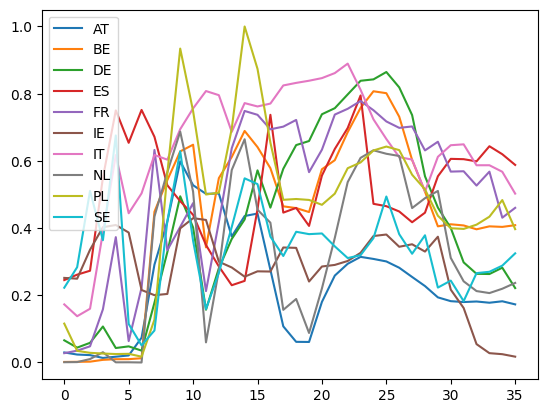

In [161]:
risk.loc[:,:].plot()